<img src="a20_a21_a22_jaccard.svg" style="text-align:center;width:50%;display:inline;"><img src="a20_a21_a22_partial.svg" style="text-align:center;width:50%;display:inline;">

# Aspect

### Aspect properties:
* __simple__ — Expressing a simple fact. Examples: 'Rover eats bones.', 'Rover ate a bone.'
* __perfect__ — Expressing a completed action. Exapmle: 'Rover has eaten a bone.'
* __progressive__ — Expressing an ongoing, habitual, or incomplete action. Example: 'Rover is eating a bone.'
* __perfect progressive__ — Expressing the end of an ongoing action. Example: 'Rover has been eating a bone.'


Let's see the distribution of properties across all sentences which have `Aspect` as a feature.

The most common property of `Aspect` is `Simple`. We'll remove all the sentences where all annotators and GPT agree on `Aspect:Simple`, and analyse the remaining sentences to understand the challenges of the `Aspect` feature.



In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)
connection = utils.connectDB()

In [3]:
FEATURE = "Aspect"
majority_property = 'simple'

In [5]:
# IMPORTANT: GPT data was corrected. Read the corrected GPT sheet NOT the database
gpt_df = pd.read_csv("data/GPT/corrected_GPT_min.csv")

In [6]:
# When this data is read in the majority_prop Type is incomaptible with the script downstream, so we just recreate this column each time
gpt_df['majority_prop'] = [list(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df['all_properties']]

In [7]:
gpt_df.head()

,sentence_id,all_properties,feature_id,majority_prop
0,265,"[{'simple'}, {'simple'}, {'simple'}, {'simple'...",Aspect,[simple]
1,265,"[{'indicative'}, {'indicative'}, {'indicative'}]",Mood,[indicative]
2,265,[],Verb_choices,[]
3,265,"[{'subordinate'}, {'subordinate', 'adjective'}...",Modifying_clauses,"[subordinate, adjective]"
4,265,"[{'multiplying and embedding modifiers', 'sing...",Modifying_phrases,"[single word modifiers, multiplying and embedd..."


In [8]:
query = 'select * from annotations where annotator_id in (20,21,22) and completed=1;'
annotations = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


### Format the human annotations like GPT for making comaprisons
This will roll the annotations up to the sentence level

In [9]:
a_20 = utils.annotationsToGPTFormat(20,annotations)
a_21 = utils.annotationsToGPTFormat(21,annotations)
a_22 = utils.annotationsToGPTFormat(22,annotations)

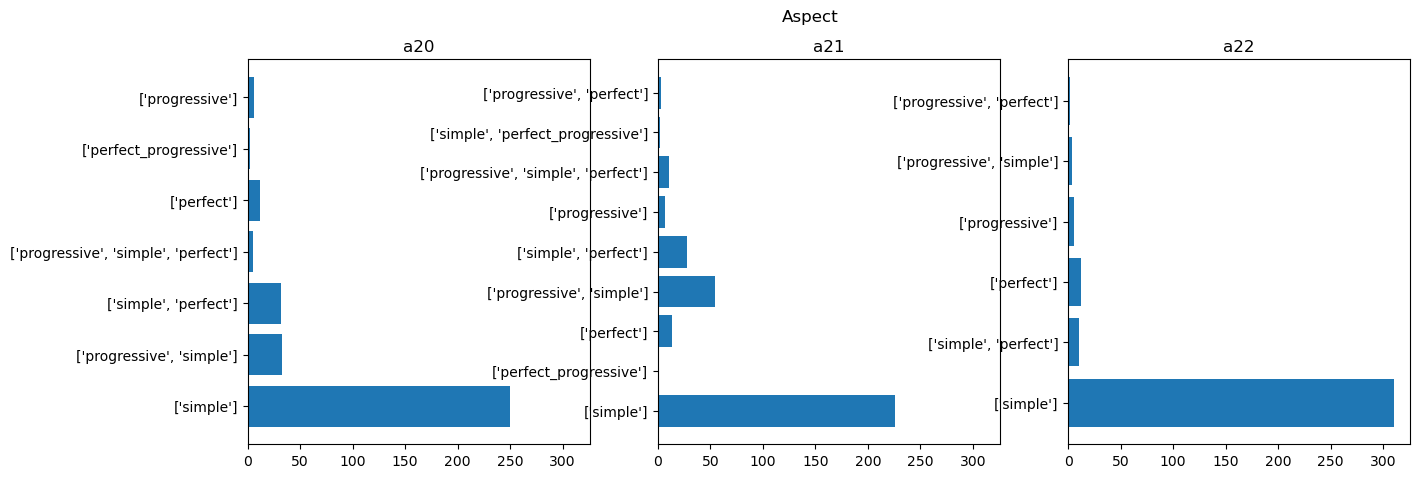

In [10]:
utils.plotPropertyDistributions(FEATURE,a_20,a_21,a_22)

In [11]:
features_gpt = list(gpt_df.groupby('feature_id').agg(list).reset_index()['feature_id'])
idx_gpt = features_gpt.index(FEATURE)
gpt_df_properties = gpt_df.groupby('feature_id').agg(list).reset_index().loc[idx_gpt][['all_properties','sentence_id']]
cGPT = Counter([str(utils.find_majority(ast.literal_eval(l))[0]) for l in gpt_df_properties['all_properties']])

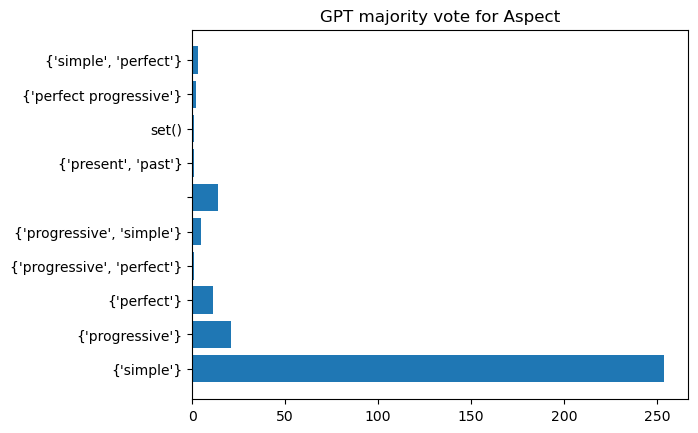

In [12]:
plt.barh(list(cGPT.keys()),list(cGPT.values()))
plt.title("GPT majority vote for "+FEATURE)
plt.show()

### Find all the sentences where there is agreement on the majority property

In [13]:
a_20_sent = set(a_20[a_20['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_21_sent = set(a_21[a_21['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
a_22_sent = set(a_22[a_22['properties'].apply(lambda x: x == [majority_property])]['sentence_id'])
gpt_df_sent = set(gpt_df[gpt_df['majority_prop'].apply(lambda x: x == [majority_property])]['sentence_id'])

In [14]:
all_agreed_sentences = a_20_sent.intersection(a_21_sent,a_22_sent,gpt_df_sent)

In [15]:
len(all_agreed_sentences)

172

### Find all the sentences (and the respective annotations) that are not in the agreed sentences list

### Find all sentences

In [16]:
query = 'SELECT id, technique, text FROM ebdb.sample_sentences;'
non_agreed_sentences = pd.read_sql(query, connection)

/Users/kylehamilton/opt/anaconda3/envs/annotation/lib/python3.9/site-packages/pandas/io/sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [17]:
non_agreed_sentences['feature_id'] = FEATURE
non_agreed_sentences['props_a20'] = ''
non_agreed_sentences['props_a21'] = ''
non_agreed_sentences['props_a22'] = ''
non_agreed_sentences['props_gpt'] = ''

In [18]:
non_agreed_sentences = non_agreed_sentences[['id', 'technique', 'text', 'feature_id', 'props_a20', 'props_a21', 'props_a22', 'props_gpt']]
non_agreed_sentences = non_agreed_sentences.rename(columns={'id':'sentence_id'})

In [19]:
non_agreed_sentences.head()

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,,,,
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,,,,
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,,,,
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,,,,
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,,,,


In [20]:
utils.fillInAnnotations(non_agreed_sentences,a_20,a_21,a_22,gpt_df,FEATURE)

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,[simple],[simple],[simple],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,[simple],[perfect_progressive],[simple],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,[simple],[simple],[simple],
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,[simple],[simple],[simple],
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,[simple],[simple],[simple],
...,...,...,...,...,...,...,...,...
352,14484,[],"They noted Haig's LinkedIn page, which says he...",Aspect,[simple],[simple],[simple],[simple]
353,14506,[],"When asked about the threats, Haig said, “I’ve...",Aspect,"[simple, perfect]","[progressive, simple, perfect]","[simple, perfect]",[simple]
354,14878,[],"In 1953, the CIA was in the process of develop...",Aspect,"[progressive, simple]","[progressive, simple]",[simple],[progressive]
355,15168,[],"“If code is speech, the constitutional contrad...",Aspect,[simple],[simple],[simple],[simple]


In [23]:
non_agreed_sentences.head()

,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,[simple],[simple],[simple],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,[simple],[perfect_progressive],[simple],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,[simple],[simple],[simple],
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,[simple],[simple],[simple],
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,[simple],[simple],[simple],


In [24]:
non_agreed_sentences.to_csv("data/clean-annotated-data/non_agreed_sentences_"+FEATURE+".csv",index=None)

### Find rows with missing GPT responses

In [62]:
to_reprompt = non_agreed_sentences[non_agreed_sentences['props_gpt']=='']

In [168]:
print(len(to_reprompt))
to_reprompt.head()

44


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,props_gpt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,[simple],[simple],[simple],
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,[simple],[perfect_progressive],[simple],
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,[simple],[simple],[simple],
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,[simple],[simple],[simple],
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,[simple],[simple],[simple],


### Reprompt GPT 3 times and merge with non_agreed_sentences

In [ ]:
# model = "gpt-3.5-turbo-0301"
# model = "gpt-3.5-turbo-0613"
# model = "gpt-3.5-turbo-1106"
# model = "gpt-4"

In [121]:
import GPT
importlib.reload(GPT)

<module 'GPT' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/GPT.py'>

In [151]:
def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    responses = []
    gpt = GPT.GPT("gpt-3.5-turbo-1106")

    for row in tqdm(to_reprompt.iterrows()):
        sentence = row[1]['text']
        feature = row[1]['feature_id']
        sid = row[1]['sentence_id']
        promt, response = gpt.get_gpt_response(sentence,feature,sid)
        responses.append([sid, response])

    df = pd.DataFrame(responses, columns=['sentence_id','res'+str(i)])
    df['gpt_props'+str(i)] = df['res'+str(i)].apply(parseRes)
    non_agreed_sentences = non_agreed_sentences.merge(df, how='outer',on='sentence_id')
    non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

    print(f"There were {len(gpt.errors)} errors in round {i}.")

44it [00:56,  1.27s/it]


In [12]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

185


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']","{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],"['simple', 'progressive']",0
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,['simple'],['perfect_progressive'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""progressive""],\n ""Explan...",['progressive'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],['simple'],1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],timeout,[],"{\n ""Properties"": [""simple""],\n ""Explana...",['simple'],['simple'],['simple'],1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""progressive""],\n ""Explan...",['progressive'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']","{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],"['simple', 'progressive']",0
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""simple""],\n ""Explana...",['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],['simple'],['simple'],1


In [15]:
# get the majority vote from the annotators (props_a20, props_a21, props_a22)
# What to do when there is no majority? NA?

# remove NaNs since they screw up the majority counting
non_agreed_sentences[['props_a20','props_a21','props_a22']] = non_agreed_sentences[['props_a20','props_a21','props_a22']].fillna('[]')

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a20']+", "+\
                                           non_agreed_sentences['props_a21']+", "+\
                                           non_agreed_sentences['props_a22']

def convert(x):
    # try: result = ast.literal_eval(x)
    # except: result = [[]]
    # return result
    return list(ast.literal_eval(x))

non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(convert)
non_agreed_sentences['props_a_majority'] = non_agreed_sentences['props_a_majority'].apply(lambda l: utils.find_majority(l)[0])

In [16]:
non_agreed_sentences.loc[35]

sentence_id                                                         313
technique                                                           [3]
text                  “The Prologue set this choice before us, the w...
feature_id                                                       Aspect
props_a20                                                    ['simple']
props_a21                                                            []
props_a22                                                    ['simple']
res1                                                                NaN
gpt_props1                                                           []
res2                                                                NaN
gpt_props2                                                           []
res3                                                                NaN
gpt_props3                                                           []
props_a_majority                                               [

In [25]:
def get_gpt4Majority(row):
    if type(row['res1']) != str:
        return row['props_gpt_majority']
    else:
        return []

non_agreed_sentences['props_gpt4_majority'] = non_agreed_sentences.apply(lambda x: get_gpt4Majority(x), axis=1)
non_agreed_sentences.loc[1]

sentence_id                                                           11
technique                                                          [0 8]
text                   We are simply asked to take the pope’s word fo...
feature_id                                                        Aspect
props_a20                                                     ['simple']
props_a21                                        ['perfect_progressive']
props_a22                                                     ['simple']
res1                   {\n  "Properties": ["simple"],\n  "Explanation...
gpt_props1                                                    ['simple']
res2                   {\n  "Properties": ["progressive"],\n  "Explan...
gpt_props2                                               ['progressive']
res3                   {\n  "Properties": ["simple", "progressive"],\...
gpt_props3                                     ['simple', 'progressive']
props_a_majority                                   

In [229]:
# Merge the previous gpt props with the newly reprompted ones into a single column
def convert(x):
    try: result = list(ast.literal_eval(x))
    except: result = []
    return result

non_agreed_sentences['props_gpt'] = non_agreed_sentences['props_gpt'].apply(convert)
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'] + non_agreed_sentences['props_gpt']
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt'], axis=1)


In [5]:
non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

In [6]:
# save the final version
non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)

In [7]:
# Sanity check
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")
print(len(non_agreed_sentences))
non_agreed_sentences.head()

185


,sentence_id,technique,text,feature_id,props_a20,props_a21,props_a22,res1,gpt_props1,res2,gpt_props2,res3,gpt_props3,props_a_majority,props_gpt_majority,ann_gpt_agreemnt
0,4,[0 8 9],"Muhammad advises the same thing, according to ...",Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']","{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],"['simple', 'progressive']",0
1,11,[0 8],We are simply asked to take the pope’s word fo...,Aspect,['simple'],['perfect_progressive'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""progressive""],\n ""Explan...",['progressive'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],['simple'],1
2,14,[0],Conservative Ben Shapiro told Fox news the ver...,Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],timeout,[],"{\n ""Properties"": [""simple""],\n ""Explana...",['simple'],['simple'],['simple'],1
3,16,[0],"According to Breitbart, “Sellner, who describe...",Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""progressive""],\n ""Explan...",['progressive'],"{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']","{\n ""Properties"": [""simple"", ""progressive""],\...","['simple', 'progressive']",['simple'],"['simple', 'progressive']",0
4,23,[0],“This is a clear violation of the Senate Ethic...,Aspect,['simple'],['simple'],['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],"{\n ""Properties"": [""simple""],\n ""Explana...",['simple'],"{\n ""Properties"": [""simple""],\n ""Explanation...",['simple'],['simple'],['simple'],1


# FIX ALL THE ERRORS
(Majorities are calculated at the list level, not the item level for both annotators and GPT)

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import utils
import importlib
import ast
from tqdm import tqdm
import re

In [2]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/annotation-app/rhetoric-annotation/results/utils.py'>

In [3]:
FEATURE = "Aspect"

In [4]:
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")

def parseRes(x):
    try:
        result = utils.parseGPTresponse(x)[1][0]
    except:
        result = []
    return result

for i in range(1,4):
    non_agreed_sentences['gpt_props'+str(i)] = non_agreed_sentences['res'+str(i)].apply(parseRes)

def listOfLists(*lists):
    new_list = []
    for l in lists:
        if len(l):
            new_list.append(l)
    return new_list

non_agreed_sentences['props_gpt_list'] = non_agreed_sentences.apply(lambda x: listOfLists(x['gpt_props1'],
                                                                                          x['gpt_props2'],
                                                                                          x['gpt_props3']), axis=1)
def find_majority(row):
    if len(row.props_gpt_list):
        return utils.find_majority(row.props_gpt_list)[0]
    else:
        return row.props_gpt_majority
    
non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences.apply(lambda x: find_majority(x),axis=1)
non_agreed_sentences = non_agreed_sentences.drop(['props_gpt_list'], axis=1)

def replaceSpaces(x):
    x = ast.literal_eval(x)
    x = [i.replace(" ","_") for i in x]
    return x

non_agreed_sentences['props_gpt_majority'] = non_agreed_sentences['props_gpt_majority'].apply(replaceSpaces)

non_agreed_sentences['ann_gpt_agreemnt'] = non_agreed_sentences.apply(lambda x: utils.calcAgreement(x['props_a_majority'],x['props_gpt_majority']), axis=1)

non_agreed_sentences.to_csv("non_agreed_sentences_"+FEATURE+".csv",index=None)
non_agreed_sentences = pd.read_csv("non_agreed_sentences_"+FEATURE+".csv")


In [1]:
non_agreed_sentences

NameError: name 'non_agreed_sentences' is not defined